In [42]:
# import libraries
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [43]:
# define a dataset
class MyDataset(Dataset):
    def __init__(self, path_data):
        self.data = torch.load(path_data)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]


In [44]:
# Define a Generative adversarial network
class GAN(torch.nn.Module):
    def __init__(self, dim_in):
        super(GAN, self).__init__()
        # define the generator
        self.generator = torch.nn.Sequential(
            torch.nn.Linear(dim_in, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 4),
        )
        # define the discriminator
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(4, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(self.generator(x))

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
input_dim = 10

dataset = MyDataset('data/extreme_yields.pt')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [46]:
model = GAN(input_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [47]:
# training loop
nb_epochs = 100


for epoch in range(nb_epochs):
    for i, data in enumerate(dataloader):
        model.discriminator.requires_grad_(True)
        model.generator.requires_grad_(False)
        # train the discriminator
        optimizer.zero_grad()
        # train on real data
        real_data = data.float().to(device)
        prediction_real = model.discriminator(real_data)
        error_real = -torch.log(prediction_real).mean()
        error_real.backward()
        # train on fake data
        noise = torch.normal(0, 1, size=(batch_size, input_dim)).to(device)
        fake_data = model.generator(noise).detach()
        prediction_fake = model.discriminator(fake_data)
        error_fake = -torch.log(1 - prediction_fake).mean()
        error_fake.backward()
        # update the discriminator
        optimizer.step()
        # train the generator
        optimizer.zero_grad()
        model.discriminator.requires_grad_(False)
        model.generator.requires_grad_(True)
        noise = torch.randn(batch_size, input_dim).to(device)
        fake_data = model.generator(noise)
        prediction_fake = model.discriminator(fake_data)
        error_generator = -torch.log(prediction_fake).mean()
        error_generator.backward()
        # update the generator
        optimizer.step()
        # print the results
        if i % 10 == 0:
            print('Epoch: {}/{}, Step: {}/{}, D(x): {:.4f}, D(G(z)): {:.4f}'.format(
                epoch, 100, i, len(dataloader), error_real.item(), error_fake.item()
            ))

Epoch: 0/100, Step: 0/63, D(x): 1.1194, D(G(z)): 0.6148
Epoch: 0/100, Step: 10/63, D(x): 0.1369, D(G(z)): 0.6590
Epoch: 0/100, Step: 20/63, D(x): 0.0335, D(G(z)): 0.7105
Epoch: 0/100, Step: 30/63, D(x): 0.0221, D(G(z)): 0.7547
Epoch: 0/100, Step: 40/63, D(x): 0.0226, D(G(z)): 0.7834
Epoch: 0/100, Step: 50/63, D(x): 0.0448, D(G(z)): 0.7915
Epoch: 0/100, Step: 60/63, D(x): 0.1409, D(G(z)): 0.6391
Epoch: 1/100, Step: 0/63, D(x): 0.1994, D(G(z)): 0.6747
Epoch: 1/100, Step: 10/63, D(x): 0.2288, D(G(z)): 0.6359
Epoch: 1/100, Step: 20/63, D(x): 0.1537, D(G(z)): 0.6179
Epoch: 1/100, Step: 30/63, D(x): 0.1931, D(G(z)): 0.6629
Epoch: 1/100, Step: 40/63, D(x): 0.1906, D(G(z)): 0.6810
Epoch: 1/100, Step: 50/63, D(x): 0.2539, D(G(z)): 0.6784
Epoch: 1/100, Step: 60/63, D(x): 0.3138, D(G(z)): 0.6814
Epoch: 2/100, Step: 0/63, D(x): 0.2972, D(G(z)): 0.6168
Epoch: 2/100, Step: 10/63, D(x): 0.3495, D(G(z)): 0.5370
Epoch: 2/100, Step: 20/63, D(x): 0.4756, D(G(z)): 0.6077
Epoch: 2/100, Step: 30/63, D(x): 0

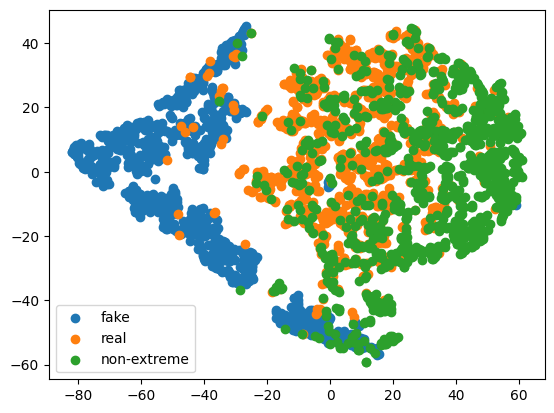

In [52]:
# plot the results with tsne
model.eval()

noise = torch.randn(1000, input_dim).to(device)
fake_data = model.generator(noise).detach().cpu()
real_data = dataset.data
non_extreme_data = torch.load('data/non_extreme_yields.pt')

tsne = TSNE(n_components=2, perplexity=30, learning_rate=100, n_iter=1000)
data = np.concatenate((fake_data, real_data, non_extreme_data[:1000]), axis=0)
data_tsne = tsne.fit_transform(data)
fake_data_tsne = data_tsne[:1000, :]
real_data_tsne = data_tsne[1000:2000, :]
non_extreme_data_tsne = data_tsne[2000:, :]
# fake_data_tsne = tsne.fit_transform(fake_data)
# real_data_tsne = tsne.fit_transform(real_data)

plt.scatter(fake_data_tsne[:, 0], fake_data_tsne[:, 1], label='fake')
plt.scatter(real_data_tsne[:, 0], real_data_tsne[:, 1], label='real')
plt.scatter(non_extreme_data_tsne[:, 0], non_extreme_data_tsne[:, 1], label='non-extreme')
plt.legend()
plt.show()
